In [4]:
from math import tanh
import numpy as np
import scipy.stats as st 
import matplotlib.pyplot as plt 
import pymc as pm
import arviz as az

def a(S_r, b, c, d):
    return S_r - b * np.tanh(c * d)

def b(S_r, F_bar):
    return (S_r - max(S_r - F_bar, 0)) / F_bar

def B(g, a, b, c, d):
    return a + b * np.tanh(-c * (g - d))

def B_equiv(g, S_r, b):
    _c = 1.0
    _d = 1.0
    _a = a(S_r, b, _c, _d)
    return B(g, _a, b, _c, _d)

def B_approx(g, S_r, b):
    return S_r - b * (1523/2000 - (3/4) * (1 - g))

def F(credit_supply, space_pledged, history_size, min_replication_factor):
    return credit_supply / max((space_pledged/min_replication_factor - history_size), 1)

<img src="media/beta.png" height=200>

In [16]:
# N_YEARS = 4
# BLOCK_TIME_IN_SECONDS = 10
# BLOCKS_PER_DAY = 24 * 60 * 60 / BLOCK_TIME_IN_SECONDS
# BLOCKS_PER_YEAR = BLOCKS_PER_DAY * 365.25
# BLOCKS_PER_N_YEARS = BLOCKS_PER_YEAR * N_YEARS
# MAX_DISBURSAL_DURING_N_YEARS = 500_000_000 # 500 Million
# MAX_AVG_BLOCK_REWARD_DURING_N_YEARS = MAX_DISBURSAL_DURING_N_YEARS / BLOCKS_PER_N_YEARS
# MIN_DISBURSAL_DURING_N_YEARS = MAX_DISBURSAL_DURING_N_YEARS / 10
# MIN_AVG_BLOCK_REWARD_DURING_N_YEARS = MIN_DISBURSAL_DURING_N_YEARS / BLOCKS_PER_N_YEARS

model = pm.Model()

KB = 2 ** (1 * 10)
MB = 2 ** (2 * 10)
GB = 2 ** (3 * 10)
TB = 2 ** (4 * 10)
PB = 2 ** (5 * 10)
EB = 2 ** (6 * 10)
ZB = 2 ** (7 * 10)
world_datasphere_size = 15 * ZB
max_credit_supply = 1_000_000_000
max_block_size = 1000 # HACK
with model:

    utilization_ratio = pm.Beta('g', alpha=1.1, beta=10)
    reference_subsidy = pm.Triangular('S_r', c=15.0, lower=0.0, upper=1_000.0)

    credit_supply_in_credits = pm.Uniform('C', 0.0, max_credit_supply)
    space_pledged_in_bytes = pm.Uniform('S', 0.0, world_datasphere_size)
    history_size_in_bytes = pm.Uniform('H', 0.0, world_datasphere_size)
    min_replication_factor = pm.DiscreteUniform('Rf', 0, 1000)

    _F = pm.math.switch(space_pledged_in_bytes/min_replication_factor - history_size_in_bytes > 0, space_pledged_in_bytes/min_replication_factor - history_size_in_bytes, 1.0)
    F = pm.Deterministic('F', _F)

    Fbar = pm.Deterministic('Fbar', F * max_block_size)

    _b = pm.math.switch(reference_subsidy - Fbar > 0, 1.0, reference_subsidy / Fbar)

    linear_sensitivity = pm.Deterministic('b', _b)


    reward_approx = pm.Deterministic('B_approx', B_approx(utilization_ratio, reference_subsidy, linear_sensitivity))
    reward_true = pm.Deterministic('B_true', B_equiv(utilization_ratio, reference_subsidy, linear_sensitivity))
    error = pm.Deterministic('B_error', reward_true - reward_approx)

    idata = pm.sample(draws=10_000)



# credit_supply_samples = None
# space_pledged_sampels = None
# history_size_samples = None
# min_replication_factor_samples = None

# Fbar_samples = F(credit_supply, space_pledged, history_size, min_replication_factor)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [g, S_r, C, S, H]
>Metropolis: [Rf]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 6 seconds.


In [34]:
ds = idata.posterior[['B_error', 'g', 'S_r', 'b']]

In [45]:
df = ds.to_dataframe().reset_index().drop(columns=['chain', 'draw'])

In [46]:
import seaborn as sns

AttributeError: QuadMesh.set() got an unexpected keyword argument 'index'

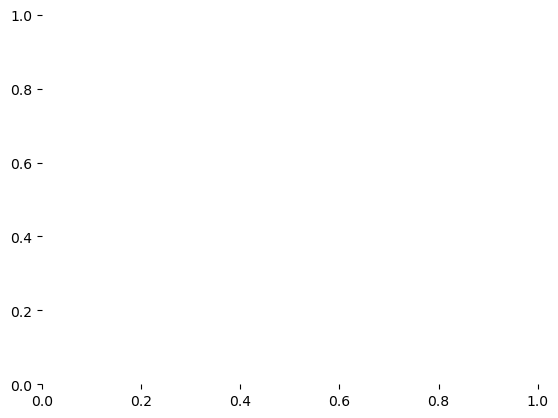

In [49]:
sns.heatmap(df, index='g', columns='S_r', values='B_error')